# TorchVision 0.3 Object Detection Template for IDTReeS

For this tutorial, we will be finetuning a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model.

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [5]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-8jc70ous
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-8jc70ous
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263917 sha256=6c4ab47f4134eb8aff548bb4efdde4b69062cbf09975f3c3ca619095d5363c0e
  Stored in directory: /tmp/pip-ephem-wheel-cache-x605t3_a/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


### Setting up the IDTrees Dataset

Here we set up the data set from IDTrees:

In [6]:
%%shell

# download the IDTrees dataset
wget https://zenodo.org/record/3934932/files/IDTREES_competition_test_v2.zip .
# extract it in the current folder
unzip IDTREES_competition_test_v2.zip

wget https://zenodo.org/record/3934932/files/IDTREES_competition_train_v2.zip .
unzip IDTREES_competition_train_v2.zip

--2021-05-10 01:42:27--  https://zenodo.org/record/3934932/files/IDTREES_competition_test_v2.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242074557 (231M) [application/octet-stream]
Saving to: ‘IDTREES_competition_test_v2.zip’

IDTREES_competition 100%[===================>] 230.86M  19.4MB/s    in 13s     

2021-05-10 01:42:41 (17.9 MB/s) - ‘IDTREES_competition_test_v2.zip’ saved [242074557/242074557]

--2021-05-10 01:42:41--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2021-05-10 01:42:41--
Total wall clock time: 14s
Downloaded: 1 files, 231M in 13s (17.9 MB/s)
Archive:  IDTREES_competition_test_v2.zip
  inflating: neon_aop_bands.csv      
   creating: task1/
   creating: task1/RemoteSensing/
   creating: task1/RemoteSensing/CHM/
  inflating: task1/RemoteSensing/CHM/MLBS

In [7]:
%%shell
pip install rasterio
pip install geopandas
pip install pyshp

     |████████████████████████████████| 19.1MB 78.0MB/s 
     |████████████████████████████████| 1.0MB 8.7MB/s 
     |████████████████████████████████| 15.3MB 220kB/s 
     |████████████████████████████████| 6.5MB 27.3MB/s 
     |████████████████████████████████| 225kB 8.1MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-cp37-none-any.whl size=37264 sha256=bd4cb0b1e96f19412f5903332999309d8200e055c13cd14308b47e3f948b1d5a
  Stored in directory: /root/.cache/pip/wheels/76/2b/d4/53e6b9a0fb0a9f9f29664cf82605af8bc81d5ab44d987896dd
Successfully built pyshp


In [8]:
import os
import random
import re

import numpy as np
import pandas as pd
import torch
import torch.utils.data # ???
import rasterio
import shapefile # pip3 install pyshp

from PIL import Image

## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


Let's write a `torch.utils.data.Dataset` class for this dataset.

In [19]:
from collections import defaultdict

class IDTreesDataset(torch.utils.data.Dataset):
    def __init__(self, rgb_path, transforms=None,
                 mlbs_shp_path = "train/ITC/train_MLBS",
                 osbs_shp_path = "train/ITC/train_OSBS",
                 csv_path = "train/Field/itc_rsFile.csv"):

        # Directory of .tif RGB images
        self.rgb_path = rgb_path

        # Transforms to apply to the images (for example, for data augmentation)
        self.transforms = transforms

        # Load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(self.rgb_path)))
        self.imgs = [filename.strip('.tif') for filename in self.imgs if '.tif' in filename]

        # Necessary in order to convert bounding boxes to pixels
        self.imgs_transform = dict()

        # Load bounding boxes
        self.bboxes = dict()
        self.bbox_shapes = self.__read_bboxes(mlbs_shp_path, osbs_shp_path, csv_path)
        
    
    def __load_img(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(self.rgb_path, f'{img_name}.tif')

        with rasterio.open(img_path) as rasterio_img:
            h, w = rasterio_img.read(1).shape
            self.imgs_transform[img_name]=rasterio_img.transform
    
            # 3 color channels in RGB
            img_array = np.zeros((h, w, 3))
            for i in range(3):
                band = rasterio_img.read(i+1)
                img_array[:, :, i] = band
    
            img_array = img_array.astype(np.uint8)
            img = Image.fromarray(img_array)
            return img

    def __read_bboxes(self, mlbs_shp_path, osbs_shp_path, csv_path):
        mlbs_shape = shapefile.Reader(mlbs_shp_path)
        osbs_shape = shapefile.Reader(osbs_shp_path)

        refs = pd.read_csv(csv_path)
        refs['rsFile'] =  [re.sub("\.tif.*$", "", x) for x in refs['rsFile']]
        key_to_name = dict(zip(refs['indvdID'], refs['rsFile']))
    
        record_shapes = defaultdict(list)
        for feature in mlbs_shape.shapeRecords():
            name = key_to_name[feature.record.indvdID]
            record_shapes[name].append(feature.shape.bbox)
        for feature in osbs_shape.shapeRecords():
            name = key_to_name[feature.record.indvdID]
            record_shapes[name].append(feature.shape.bbox)

        return record_shapes

    def __get_bboxes(self, idx):

        img_name = self.imgs[idx]

        # Check if we already computed the boxes 
        if img_name in self.bboxes:
            return self.bboxes[img_name]
        
        # Compute the boxes
        boxes = []
        transform = self.imgs_transform[img_name]
        for v in self.bbox_shapes[img_name]:
            rows, cols = rasterio.transform.rowcol(transform,[v[0],v[2]], [v[1],v[3]])
            #NOTE should this need to be switched? - need to follow up with Rebekah
            boxes.append([rows[1],cols[0],rows[0],cols[1]])
        self.bboxes[img_name] = boxes
        return boxes
    

    def __getitem__(self, idx):
        img_name = self.imgs[idx]

        img   = self.__load_img(idx)
        boxes = self.__get_bboxes(idx)

        # Note: do this step every time. do not save the tensor in self.bboxes
        #       or else you will crash
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # There is only one class
        labels = torch.ones((len(boxes),), dtype=torch.int64)

        image_id = torch.tensor([idx])
        if len(boxes) > 0:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            boxes = torch.as_tensor([[0.0,0.0,0.1,0.1]], dtype=torch.float32)
            area = torch.as_tensor([0.0], dtype=torch.float32) 
            labels = torch.ones((len(boxes),), dtype=torch.int64)
            print("SOMETHING IS WRONG", self.imgs[idx])
        
        # Suppose all instances are not crowd
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        if len(boxes) < 1:
            print(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That's all for the dataset. Let's see how the outputs are structured for this dataset

<PIL.Image.Image image mode=RGB size=200x200 at 0x7F553D9A8890> {'boxes': tensor([[  0., 161.,  29., 199.],
        [  2.,   0.,  46.,  39.],
        [ 13.,  51.,  56.,  99.],
        [ 35.,  27.,  73.,  60.],
        [ 19.,  60.,  78., 145.],
        [ 56., 136.,  90., 180.],
        [  7., 132.,  66., 199.],
        [ 63., 154., 114., 199.],
        [ 35.,   0., 113.,  30.],
        [ 66.,  91., 112., 144.],
        [ 90., 116., 129., 157.],
        [128.,  48., 190.,  90.],
        [103.,  70., 139., 111.],
        [128.,  84., 196., 155.],
        [130., 157., 173., 199.],
        [126.,  30., 176.,  54.],
        [ 75.,  67., 105.,  94.],
        [ 44.,   4., 131.,  76.],
        [123.,   3., 159.,  30.],
        [  0.,  70.,  15., 122.],
        [157., 156., 196., 199.],
        [  5.,  33.,  45.,  61.]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'image_id': 'MLBS_1', 'area': tensor([1102., 1716., 2064., 1254., 5015., 1496., 3953., 229

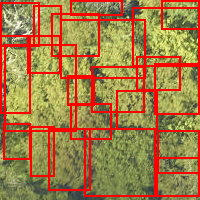

In [10]:
dataset = IDTreesDataset('./train/RemoteSensing/RGB/')

img, target = dataset[0]
print(img, target)

from PIL import Image, ImageDraw

bb_img = img
bb_draw_img = ImageDraw.Draw(bb_img)

boxes = target['boxes']
for box in boxes:
  box = [int(coord) for coord in box]
  shape = [(box[1], box[0]), (box[3], box[2])]
  bb_draw_img.rectangle(shape, outline ="red", width=2)

print(len(boxes))
bb_img

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

## Defining your model

In this tutorial, we will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

![Mask R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image04.png)

There are two common situations where one might want to modify one of the available models in torchvision modelzoo.
The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).

Let's go see how we would do one or another in the following sections.


### 1 - Finetuning from a pretrained model

Let's suppose that you want to start from a model pre-trained on COCO and want to finetune it for your particular classes. Here is a possible way of doing it:
```
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
```

### 2 - Modifying the model to add a different backbone

Another common situation arises when the user wants to replace the backbone of a detection
model with a different one. For example, the current default backbone (ResNet-50) might be too big for some applications, and smaller models might be necessary.

Here is how we would go into leveraging the functions provided by torchvision to modify a backbone.

```
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
```

### An Instance segmentation model for PennFudan Dataset

In our case, we want to fine-tune from a pre-trained model, given that our dataset is very small. So we will be following approach number 1.

Here we want to also compute the instance segmentation masks, so we will be using Mask R-CNN:

In [11]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
# def get_instance_segmentation_model(num_classes):
#     # load an instance segmentation model pre-trained on COCO
#     model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

#     # get the number of input features for the classifier
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     # replace the pre-trained head with a new one
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#     return model

In [12]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.rpn import RPNHead

def get_instance_segmentation_model(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # create an anchor_generator for the FPN
  # which by default has 5 outputs
  anchor_generator = AnchorGenerator(
      sizes=tuple([(16, 32, 64, 128, 256, 512) for _ in range(5)]),
      aspect_ratios=tuple([(0.25, 0.5, 1.0, 2.0) for _ in range(5)]))
  model.rpn.anchor_generator = anchor_generator

  # 256 because that's the number of features that FPN returns
  model.rpn.head = RPNHead(256, anchor_generator.num_anchors_per_location()[0])
  # get the number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  return model


That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook

In [13]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 23637, done.
remote: Counting objects: 100% (1098/1098), done.
remote: Compressing objects: 100% (282/282), done.
remote: Total 23637 (delta 812), reused 1054 (delta 794), pack-reused 22539
Receiving objects: 100% (23637/23637), 30.78 MiB | 28.50 MiB/s, done.
Resolving deltas: 100% (17501/17501), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version




Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [14]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [20]:
from torch.utils.data import random_split, Subset

# use our dataset and defined transformations
dataset_train = IDTreesDataset('./train/RemoteSensing/RGB/', get_transform(train=True))
dataset_valid = IDTreesDataset('./train/RemoteSensing/RGB/', get_transform(train=False))

full_len = len(dataset_train)
split = list(range(full_len))
random.shuffle(split)
frac_valid = 0.2
split_idx = int(full_len * frac_valid)

# Sorry this is kinda ugly but I want to make sure the transformations are separate
dataset_train = Subset(dataset_train, split[split_idx:])
dataset_valid = Subset(dataset_valid, split[:split_idx])

# dataset_train, dataset_valid = random_split(full_training_set, [n_train, n_valid])
# dataset_valid.transform = get_transform(train=False) # I bet this doesn't work.

dataset_test = IDTreesDataset('./task1/RemoteSensing/RGB/', get_transform(train=False))

# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=8, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person (IDTreeS: Yes Tree, No Tree)
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
## let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the validation dataset
    evaluate(model, data_loader_valid, device=device)

Now that training has finished, let's have a look at what it actually predicts in a test image

In [23]:
# pick one image from the test set
img, correct = dataset_valid[10]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [ ]:
prediction

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

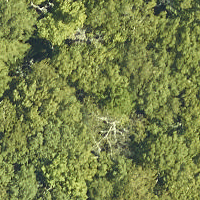

In [24]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the bounding boxes.

100


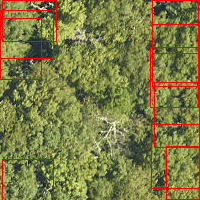

In [33]:
from PIL import Image, ImageDraw

bb_img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
bb_draw_img = ImageDraw.Draw(bb_img)

# Predicted boxes
boxes = prediction[0]['boxes']
for box in boxes[:10]:
  box = [int(coord) for coord in box]
  shape = [(box[1], box[0]), (box[3], box[2])] # bottom left, top right
  bb_draw_img.rectangle(shape, outline ="red", width=1)

# Correct boxes
boxes = correct['boxes']
for box in boxes[:10]:
  box = [int(coord) for coord in box]
  shape = [(box[1], box[0]), (box[3], box[2])]
  bb_draw_img.rectangle(shape, outline ="blue", width=1)

print(len(boxes))
bb_img

**Evaluation**

In [74]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as pat
from tqdm import tqdm

def get_det_indices(det):
  x = np.arange(det[0], det[0]+det[2], 1)
  y = np.arange(det[1], det[1]+det[3], 1)
  X,Y = np.meshgrid(x,y)
  XY=np.array([X.flatten(),Y.flatten()])
  area = np.array([200, 200]) # default
  indices = np.ravel_multi_index(XY, area, mode = 'clip')
  return set(indices)

def halo_corners(GT, im):

    # default parameters
    inner = 1
    outer = 1
    edge = 1
    #plot the inner halo
    innerCo = np.array([GT[0] + inner, GT[1] + inner, GT[2] - 2 * inner, GT[3] - 2 * inner])
    
    #plot the outer halo
    outerCo = np.array([GT[0] - outer, GT[1] - outer, GT[2] + 2 * outer, GT[3] + 2 * outer])
    
    #plot the edge halo
    edgeCo = np.array([GT[0] - edge, GT[1] - edge, GT[2] + 2 * edge, GT[3] + 2 * edge])
  
    corners = {}
    corners['inner'] = innerCo
    corners['outer'] = outerCo
    corners['edge'] = edgeCo
    
    return corners
    

def plot_corners(GT,corners,im):
    
     #plot the inner halo
    innerCo = np.array(corners['inner'])
    
    #plot the outer halo
    outerCo = np.array(corners['outer'])
    
    #plot the edge halo
    edgeCo = np.array(corners['edge'])
    
    fig,ax = plt.subplots(1)
    ax.invert_yaxis()
        
    #get GT rectangle
    rectGT = pat.Rectangle((GT[0],GT[1]),GT[2],GT[3],linewidth=2,edgecolor='r',fill=0)
    ax.add_patch(rectGT)
        
    #inner
    rectIn = pat.Rectangle((innerCo[0],innerCo[1]),innerCo[2],innerCo[3],linewidth=2,edgecolor='m',fill=0)
    ax.add_patch(rectIn)
        
    # outer
    rectOut = pat.Rectangle((outerCo[0],outerCo[1]),outerCo[2],outerCo[3],linewidth=2,edgecolor='tab:purple',fill=0)
    ax.add_patch(rectOut)
        
    #edge
    rectEdge = pat.Rectangle((edgeCo[0],edgeCo[1]),edgeCo[2],edgeCo[3],linewidth=2,edgecolor='tab:blue',fill=0)
    ax.add_patch(rectEdge)
    
    return ax,fig

def get_halo_indices(corners,GT):
    
    halo_indices = {}
    area = np.array([200,200]) # default
                    
    #get inner
    inxywh = corners['inner']
    x = np.arange(inxywh[0], inxywh[0]+inxywh[2], 1)
    y = np.arange(inxywh[1], inxywh[1]+inxywh[3], 1)
    X,Y = np.meshgrid(x,y)
    #make sure outer halo doesn't go outside plot boundaries
    XY=np.array([X.flatten(),Y.flatten()])
    indices = np.ravel_multi_index(XY,area,mode='clip')
    halo_indices['inner'] = set(indices)
    
    #get outer
    inxywh = corners['outer']
    x = np.arange(inxywh[0], inxywh[0]+inxywh[2], 1)
    y = np.arange(inxywh[1], inxywh[1]+inxywh[3], 1)
    X,Y = np.meshgrid(x,y)
    #make sure outer halo doesn't go outside plot boundaries
    XY=np.array([X.flatten(),Y.flatten()])
    indices = np.ravel_multi_index(XY,area,mode='clip')
    halo_indices['outer'] = set(indices)
    
    #get edge
    inxywh = corners['edge']
    x = np.arange(inxywh[0], inxywh[0]+inxywh[2], 1)
    y = np.arange(inxywh[1], inxywh[1]+inxywh[3], 1)
    X,Y = np.meshgrid(x,y)
    #make sure outer halo doesn't go outside plot boundaries
    XY=np.array([X.flatten(),Y.flatten()])
    indices = np.ravel_multi_index(XY,area,mode='clip')
    halo_indices['edge'] = set(indices)
    
    #set parameters based on area of gt box
    W = corners['outer'][2]
    H = corners['outer'][3]
    C = 2*W+2*H
    ww = GT[2]
    hh = GT[3]
    t = (-C+(C**2+4*ww*hh*4)**.5)/(8)
    inxywh = corners['edge']
    inxywh[0]-=t
    inxywh[1]-=t
    inxywh[2]+=2*t
    inxywh[3]+=2*t
    corners['edge'] = inxywh
    x = np.arange(inxywh[0], inxywh[0]+inxywh[2], 1)
    y = np.arange(inxywh[1], inxywh[1]+inxywh[3], 1)
    X,Y = np.meshgrid(x,y)
    #make sure outer halo doesn't go outside plot boundaries
    XY=np.array([X.flatten(),Y.flatten()])
    indices = np.ravel_multi_index(XY,area,mode='clip')
    halo_indices['edge'] = set(indices)
    
    return corners, halo_indices


def RandNeon(GT,detection,im,pname = None):
   
    #get set for detection
    det = get_det_indices(detection)
    
    #get halos
    hcorners = halo_corners(GT, im)    
        
    #get sets for each halo
    corners,halos = get_halo_indices(hcorners,GT)
     
    #if detection contains outside of edge, extend edge halo
    if det.difference(halos['edge']):
        halos['edge']=halos['edge'].union(det)
    
    #compute a
    a_set = det.intersection(halos['inner'])
    a = len(a_set)**2      
 
    #compute b
    edge_wo = halos['edge'].difference(halos['outer'])
    b_set = edge_wo.difference(det)
    b = len(b_set)**2
    
    #compute c
    out_only = halos['edge'].difference(halos['outer'])
    c_set = det.intersection(out_only)
    c = len(c_set)**2
    
    #compute d
    d_set = halos['inner'].difference(det)
    d = len(d_set)**2
         
    correct = float(a+b)
    incorrect = float(c+d)
    
    if a == 0:
        score = 0.0
    else:
        score = correct/(correct+incorrect)
    
     #plot detection
    if pname is not None:
        ax,fig = plot_corners(GT,corners,im)
        rectDet = pat.Rectangle((detection[0],detection[1]),detection[2],detection[3],linewidth=2,edgecolor='k',fill=0)
        ax.add_patch(rectDet)
        im = np.uint8(im)
        plt.imshow(np.flipud(im),origin='lower')
        plt.title('a= '+str(a)+', b = '+str(b)+', c= '+str(c)+', d= '+str(d)+'\n'+'Rand= '+str(np.round(score,2)),fontsize=10)
        fig.savefig(outputdir+"imgs/"+pname[:-4]+'.png')
        plt.close(fig)
    return score

def from_raster_to_img(im_pt):
    import rasterio
    import numpy as np

    arr = rasterio.open(im_pt)
    arr = arr.read()
    arr = np.moveaxis(arr,0,-1)
    arr = arr[:,:,::-1]

    return arr

def get_vertex_per_plot(correct, preds):
    import rasterio
    import pandas as pd
    import numpy as np

    df_corr = pd.DataFrame.from_records(correct, columns=['miny', 'minx', 'maxy', 'maxx'])
    df_preds = pd.DataFrame.from_records(preds, columns=['miny', 'minx', 'maxy', 'maxx'])
    df_corr['width'] = df_corr['maxx'] - df_corr['minx']
    df_corr['length'] = df_corr['maxy'] - df_corr['miny']
    df_preds['width'] = df_preds['maxx'] - df_preds['minx']
    df_preds['length'] = df_preds['maxy'] - df_preds['miny']

    gtf_limits = df_corr[["minx", "miny", "width", "length"]]
    gdf_limits = df_preds[["minx", "miny", "width", "length"]]

    gdf_limits = np.floor(gdf_limits).astype(int)
    gtf_limits = np.floor(gtf_limits).astype(int)

    return (gdf_limits, gtf_limits)

# slightly modified from https://gist.github.com/meyerjo/dd3533edc97c81258898f60d8978eddc
def bb_intersection_over_union(boxAA, boxBB):
    # recalculate vertices for box a and b from length weight
    boxA = boxAA.copy()
    boxB = boxBB.copy()
    boxA[2] = boxA[0] + boxA[2]
    boxA[3] = boxA[1] + boxA[3]
    boxB[2] = boxB[0] + boxB[2]
    boxB[3] = boxB[1] + boxB[3]
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

# get list of plots to evaluate
def run_segmentation_evaluation(dataset):
    import glob, os
    import numpy as np
    import pandas as pd
    from scipy.optimize import linear_sum_assignment

    evaluation_rand = np.array([])
    evaluation_iou = np.array([])
    itc_ids = np.array([])

    model.eval()

    # get ith plot
    with torch.no_grad():
      for im, info in dataset:
          prediction = model([im.to(device)])
          
          # get coordinates of groundtruth and predictions
          itc_name = str(info['image_id'])
          gdf_limits, gtf_limits = get_vertex_per_plot(info['boxes'], prediction[0]['boxes'])

          # initialize rand index maxtrix GT x Detections
          R = np.zeros((gdf_limits.shape[0], gtf_limits.shape[0]))
          iou = np.zeros((gdf_limits.shape[0], gtf_limits.shape[0]))
          pbar2 = tqdm(range(gdf_limits.shape[0]), position=0,ascii=True,leave=False)
          pbar2.set_description("Processing each detection for plot "+itc_name)
          for obs_itc in range(gdf_limits.shape[0]):
              dets = gdf_limits.iloc[obs_itc, :].values
              for det_itc in range(gtf_limits.shape[0]):
                  trues = gtf_limits.iloc[det_itc, :].values
                  # calculate rand index
                  R[obs_itc, det_itc] = RandNeon(trues, dets, im)
                  # calculate the iou
                  iou[obs_itc, det_itc] = bb_intersection_over_union(dets, trues)
              pbar2.update(1)
          # calculate the optimal matching using hungarian algorithm
          row_ind, col_ind = linear_sum_assignment(-R)
          pbar2.close
          # if par.save == 1:
          #     # redo Rindex for good pairs
          #     pairs = np.c_[row_ind, col_ind]
          #     for i in range(pairs.shape[0]):
          #         dets = gdf_limits.iloc[pairs[i, 0], :].values
          #         trues = gtf_limits.iloc[pairs[i, 1], :].values
          #         RandNeon(trues, dets, im, par, pname=str(i) + "_" + pl)
          # assigned couples
          foo = R[row_ind, col_ind]
          plot_scores = np.zeros(gtf_limits.shape[0])
          plot_scores[col_ind] = foo

          itc_ids = np.append(itc_ids, [itc_name] * plot_scores.shape[0])
          evaluation_rand = np.append(evaluation_rand, plot_scores)  # pl,plot_scores])
          # do the same for iou
          row_ind, col_ind = linear_sum_assignment(-iou)
          foo = iou[row_ind, col_ind]
          plot_scores = np.zeros(gtf_limits.shape[0])
          plot_scores[col_ind] = foo
          evaluation_iou = np.append(evaluation_iou, plot_scores)  # pl,plot_scores])

    # concatenate the three columns and save as a csv file
    task1_evaluation = np.c_[itc_ids, evaluation_rand, evaluation_iou]
    pd.DataFrame(task1_evaluation, columns=["itc_id", "rand_index", "IoU"]).to_csv(
        "validation/task1_evaluation.csv"
    )
    return (evaluation_rand, evaluation_iou)

In [75]:
(evaluation_rand, evaluation_iou) = run_segmentation_evaluation(dataset_valid)

Processing each detection for plot tensor([53]):   0%|          | 0/100 [00:00<?, ?it/s]

SOMETHING IS WRONG OSBS_16


Processing each detection for plot tensor([6]): 100%|##########| 100/100 [00:05<00:00, 18.84it/s]

Looks pretty good! ...in your dreams

## Wrapping up

In this tutorial, you have learned how to create your own training pipeline for instance segmentation models, on a custom dataset.
For that, you wrote a `torch.utils.data.Dataset` class that returns the images and the ground truth boxes and segmentation masks. You also leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-gpu training, check `references/detection/train.py`, which is present in the [torchvision GitHub repo](https://github.com/pytorch/vision/tree/v0.3.0/references/detection). 

